In [1]:
#load necessary modules
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix
from tensorflow.examples.tutorials.mnist import input_data

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
tf.__version__

'1.3.0'

In [3]:
#load dataset
mnist = input_data.read_data_sets("./mnist_data/", one_hot=True)
print(mnist.train.num_examples)

Extracting ./mnist_data/train-images-idx3-ubyte.gz
Extracting ./mnist_data/train-labels-idx1-ubyte.gz
Extracting ./mnist_data/t10k-images-idx3-ubyte.gz
Extracting ./mnist_data/t10k-labels-idx1-ubyte.gz
55000


In [4]:
train_image = mnist.train.images
train_label = mnist.train.labels
test_image = mnist.test.images
test_label = mnist.test.labels

In [5]:
#plot function
def plot_images(input_images, image_labels, image_pre_labels=None):
    assert len(input_images) == 9
    
    fig, axes = plt.subplots(3,3)
    #fig.subplots_adjust(hspace=.3, wspace=.3)
    
    for i, ax in enumerate(axes.flat):
        
        ax.imshow(input_images[i].reshape((28,28)), cmap="binary")
        if image_pre_labels == None:
            xlabel = "true:{0}".format(image_labels[i])
        else:
            xlabel = "true:{0}, predict:{1}".format(iamge_labels[i], image_pre_labels[i])
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

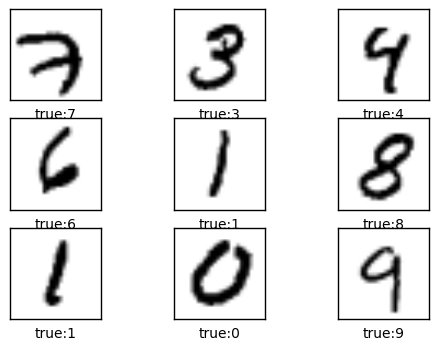

In [6]:
plot_images(train_image[:9], np.argmax(train_label[:9],axis=1))

In [7]:
# parameters for cnn
filter_size = 5
num_filters1 = 32
num_filters2 = 64
fc_size = 128

In [8]:
#define inputs
batch_size = 100

x = tf.placeholder(dtype=tf.float32, shape=[None, 784], name="images")
x_image = tf.reshape(x, [-1, 28,28,1])
y = tf.placeholder(dtype=tf.float32, shape=[None, 10], name="real_labels")

In [9]:
#define model
#conv layer1 
with tf.variable_scope("conv_layer1"):
    weight1 = tf.get_variable(name="w_layer1", \
                              shape=[filter_size,filter_size,1,num_filters1], \
                              dtype=tf.float32, \
                              initializer=tf.truncated_normal_initializer(mean=0, stddev=0.5)
                             )
    bias1 = tf.get_variable(name="b_layer1", \
                            shape=[num_filters1], \
                           initializer=tf.zeros_initializer())
    conv1 = tf.nn.conv2d(x_image, weight1, strides=[1,1,1,1], padding="SAME")
    hidden1 = tf.nn.relu(conv1 + bias1)
    layer1_out = tf.nn.max_pool(hidden1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    
#conv layer2
with tf.variable_scope("conv_layer2"):
    weight2 = tf.get_variable(name="w_layer2", \
                              shape=[filter_size,filter_size,num_filters1,num_filters2], \
                              dtype=tf.float32, \
                              initializer=tf.truncated_normal_initializer(mean=0, stddev=0.5)
                             )
    bias2 = tf.get_variable(name="b_layer2", \
                            shape=[num_filters2], \
                            dtype=tf.float32, \
                            initializer=tf.zeros_initializer()
                           )
    conv2 = tf.nn.conv2d(layer1_out, weight2, strides=[1,1,1,1], padding="SAME")
    hidden2 = tf.nn.relu(conv2 + bias2)
    layer2_out = tf.nn.max_pool(hidden2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

#fc_layer1
with tf.variable_scope("fc_layer1"):
    w_fc1 = tf.get_variable(name="w_fc1", shape=[7*7*num_filters2,1024])
    b_fc1 = tf.get_variable(name="b_fc1",shape=[1024])
    layer2_out_flat = tf.reshape(layer2_out, [-1, 7*7*num_filters2])
    fc1 = tf.nn.relu(tf.matmul(layer2_out_flat,w_fc1)+b_fc1)
    keep_prob = tf.placeholder(name="dropout_probility", dtype=tf.float32)
    fc1_dropout = tf.nn.dropout(fc1, keep_prob)
    
#fc_layer2
with tf.variable_scope("fc_layer2"):
    w_fc2 = tf.get_variable(name="w_fc2", shape=[1024, 10], \
                            initializer=tf.truncated_normal_initializer(mean=0,stddev=0.5)
                           )
    b_fc2 = tf.get_variable(name="b_fc2", shape=[10], \
                            initializer=tf.constant_initializer(0.1)
                           )
    fc2 = tf.matmul(fc1_dropout,w_fc2)+b_fc2
    


In [10]:
#define loss
cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=fc2))

In [11]:
#choose a optimizer
optimize = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy_loss)

In [12]:
#define acurracy 
eqs = tf.equal(tf.argmax(y,axis=1), tf.argmax(fc2,axis=1))
acc = tf.reduce_mean(tf.cast(eqs, tf.float32))

In [13]:
#start a session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [14]:
#train the model
for i in range(1000):
    x_batch , y_batch = mnist.train.next_batch(batch_size)
    sess.run(optimize, feed_dict={x:x_batch, y:y_batch, keep_prob:0.6})
    accuracy = acc.eval(feed_dict={x:x_batch, y:y_batch, keep_prob:1.0})
    if i % 50 == 0:
        print("round {}, the accuracy is : {:.2%}".format(i, accuracy))

round 0, the accuracy is : 33.00%
round 50, the accuracy is : 87.00%
round 100, the accuracy is : 91.00%
round 150, the accuracy is : 94.00%
round 200, the accuracy is : 91.00%
round 250, the accuracy is : 91.00%
round 300, the accuracy is : 92.00%
round 350, the accuracy is : 92.00%
round 400, the accuracy is : 96.00%
round 450, the accuracy is : 98.00%
round 500, the accuracy is : 90.00%
round 550, the accuracy is : 96.00%
round 600, the accuracy is : 95.00%
round 650, the accuracy is : 98.00%
round 700, the accuracy is : 92.00%
round 750, the accuracy is : 96.00%
round 800, the accuracy is : 95.00%
round 850, the accuracy is : 97.00%
round 900, the accuracy is : 98.00%
round 950, the accuracy is : 98.00%


In [22]:
print("test acc:{}".format(sess.run(acc,feed_dict={x:test_image,y:test_label,keep_prob:1.0})))

test acc:0.943599998951


In [19]:
test_image.shape

(10000, 784)